In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime

In [2]:
load_optimzed_model = False

# Load Data

In [3]:
kaggle_data = pd.read_csv('C:\\Users\\I539001\\Desktop\\PA2\\AL\\FeedbackBoost\\Data\\Kaggle_Plant.csv')

In [4]:
Data_id = "Kaggel_plant"

In [5]:
kaggle_data.head()

,Unnamed: 0,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,...,L_10,A_5,B_5,C_5,ts_int,cnt_per_rtf,RUL,RUL_pw,phase,IMM_FAILURE
0,1,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,...,-65.524273,-100.0,-100.0,-100.0,1,51671,51671,120,1,0
1,2,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,...,-65.524273,-100.0,-100.0,-100.0,2,51671,51670,120,1,0
2,3,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,...,-71.139518,-100.0,-100.0,-100.0,3,51671,51669,120,1,0
3,4,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,...,-68.708337,-100.0,-100.0,-100.0,4,51671,51668,120,1,0
4,5,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,...,-67.030037,-100.0,-100.0,-100.0,5,51671,51667,120,1,0


# Some Exploratory Analysis

In [6]:
kaggle_data['rtf_id'].unique()

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

In [7]:
# we only have 8 rtfs -> very few amount of data
rtf_ids = kaggle_data['rtf_id'].unique() # very few amount of data compared to cmaps (260 unique engine_ids alone in train set)
rtf_ids
# cross validation as solution to "zu wenig data"

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

# Data Preparation

In [8]:
kaggle_data= kaggle_data.drop(['Unnamed: 0', 'ts_int', 'cnt_per_rtf', 'RUL_pw', 'phase','IMM_FAILURE'], axis=1) 
# run to failure id: z.B engine_id 

In [9]:
#define train dataset and test dataset: first, without cross validation. Just manually defining
train_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[:6]))]

In [10]:
train_data

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
0,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,51671
1,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,51670
2,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-71.781622,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.000000,-100.000000,51669
3,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-57.552610,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.000000,-100.000000,51668
4,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-45.735041,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.000000,-100.000000,51667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,14,32843,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,...,-73.534037,2.981725,-88.804906,-29.331788,-92.362007,29.244765,-100.0,33.333333,53.846154,5
176654,14,32844,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,...,-73.534037,-53.350433,-85.824301,-33.498133,-92.362007,-53.948710,-100.0,-100.000000,-100.000000,4
176655,14,32845,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,...,-73.534037,-84.289836,-95.807188,-22.049697,-97.297092,-63.234256,-100.0,-100.000000,-100.000000,3
176656,14,32846,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,...,-73.534037,-84.289836,-96.434683,-31.685335,-97.297092,-63.861658,-100.0,-100.000000,-100.000000,2


In [11]:
def extract_RUL_per_rtf_id(df, rul_column_name = "RUL"): 
    RUL_per_rtf_ID = list()
    for rtf_id in df['rtf_id'].unique(): 

        RUL_per_rtf_ID.append(df.loc[df['rtf_id'] == rtf_id]['RUL'].iloc[-1])

    return   pd.DataFrame(RUL_per_rtf_ID, columns=['RUL_per_rtf_ID'])

In [12]:
extract_RUL_per_rtf_id(train_data, rul_column_name= "RUL")

,RUL_per_rtf_ID
0,2
1,1
2,1
3,1
4,2
5,1


In [13]:
y_train_RUL_per_cycle = train_data['RUL']
x_train_data = train_data.loc[:, train_data.columns!='RUL']

In [14]:
test_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[6:]))]
test_data

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0,30737
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0,30736
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0,30735
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0,30734
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0,30733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228407,16,21016,-91.921033,-54.939729,-12.645781,-24.723005,-22.313266,-24.747541,-22.298259,-24.844354,...,-20.766869,-80.250080,-87.664005,-25.706193,-92.346823,-30.123128,-100.0,-100.0,-100.0,5
228408,16,21017,-99.331815,-79.731577,-12.706761,-24.762342,-22.448703,-24.813115,-22.284708,-24.831247,...,-74.223021,-80.250080,-93.511124,-25.917343,-97.585605,-60.269783,-100.0,-100.0,-100.0,4
228409,16,21018,-99.331815,-79.731577,-12.706761,-24.736117,-22.313266,-24.826230,-22.271157,-24.857461,...,-74.223021,-80.250080,-93.511124,-26.303592,-97.585605,-59.062034,-100.0,-100.0,-100.0,3
228410,16,21019,-99.331815,-79.731577,-12.462840,-24.893464,-22.380985,-24.865574,-22.284708,-24.791926,...,-74.223021,-80.250080,-93.511124,-26.725892,-97.585605,-61.242256,-100.0,-100.0,-100.0,2


In [15]:
test_RUL_per_rtf_id = extract_RUL_per_rtf_id(test_data, rul_column_name= "RUL")

In [16]:
test_RUL_per_rtf_id

,RUL_per_rtf_ID
0,1
1,1


In [17]:
test_data['rtf_id'].unique()

array([15, 16], dtype=int64)

In [18]:
y_test_RUL_per_cycle = test_data['RUL']
x_test_data = test_data.loc[:, test_data.columns!='RUL']


In [19]:
x_test_data.head()

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_4,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-97.493393,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-75.069834,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-50.426569,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,4.552677,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,73.363560,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0


In [20]:
x_train_data.columns

Index(['rtf_id', 'cycle', 'L_1', 'L_2', 'A_1', 'A_2', 'B_1', 'B_2', 'C_1',
       'C_2', 'A_3', 'A_4', 'B_3', 'B_4', 'C_3', 'C_4', 'L_3', 'L_4', 'L_5',
       'L_6', 'L_7', 'L_8', 'L_9', 'L_10', 'A_5', 'B_5', 'C_5'],
      dtype='object')

## Computing Remaining Useful Life

## RUL for train data

In [21]:
id='rtf_id'
MAXLIFE = 2*8*60 # or 125 , 130 #sollte ein parameter sein! Cahit hat einen Weg diese parameter zu bestimmten--> soll ein input parameter sein
# piecewise linear RUL 

def piecewise_linear_rul_train(train_data, MAXLIFE): 
    rul = [] 
    for _id in set(train_data[id]):
        trainFD_of_one_id =  train_data[train_data[id] == _id]
        cycle_list = trainFD_of_one_id['cycle'].tolist()
        max_cycle = max(cycle_list)

        knee_point = max_cycle - MAXLIFE
        kink_RUL = []
        for i in range(0, len(cycle_list)):
            # 
            if i < knee_point:
                kink_RUL.append(MAXLIFE)
            else:
                tmp = max_cycle-i-1 # why substracting -1 as well?
                kink_RUL.append(tmp)
        rul.extend(kink_RUL)
    train_data["RUL"] = rul 
    return train_data 


In [22]:
for _id in set(train_data[id]):
    print(_id)

7
8
9
11
13
14


In [23]:
train_data_with_piecewise_rul = piecewise_linear_rul_train(x_train_data, MAXLIFE)

In [24]:
train_data_with_piecewise_rul

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
0,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,960
1,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-76.934022,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.000000,-100.000000,960
2,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-71.781622,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.000000,-100.000000,960
3,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-57.552610,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.000000,-100.000000,960
4,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-45.735041,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.000000,-100.000000,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,14,32843,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,...,-73.534037,2.981725,-88.804906,-29.331788,-92.362007,29.244765,-100.0,33.333333,53.846154,7
176654,14,32844,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,...,-73.534037,-53.350433,-85.824301,-33.498133,-92.362007,-53.948710,-100.0,-100.000000,-100.000000,6
176655,14,32845,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,...,-73.534037,-84.289836,-95.807188,-22.049697,-97.297092,-63.234256,-100.0,-100.000000,-100.000000,5
176656,14,32846,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,...,-73.534037,-84.289836,-96.434683,-31.685335,-97.297092,-63.861658,-100.0,-100.000000,-100.000000,4


## Rul for test data

In [25]:
def piecewise_linear_rul_test(x_test_data, MAXLIFE, rtf_id_column = 'rtf_id'): 
    id= rtf_id_column
    rul = []
    replacement_mapping_dict = {             # replacing the ids with chronoligcal 1,2,3... since the code in autorul assumes this 
        15: 1,
        16: 2
    }
    x_test_data[id] = x_test_data[id].replace(replacement_mapping_dict)

    for _id_test in set(x_test_data[id]):      
        true_rul = int(test_RUL_per_rtf_id.iloc[_id_test - 1])
        testFD_of_one_id =  x_test_data[x_test_data[id] == _id_test]
        cycle_list = testFD_of_one_id['cycle'].tolist()
        max_cycle = max(cycle_list) + true_rul
        knee_point = max_cycle - MAXLIFE
        kink_RUL = []
        for i in range(0, len(cycle_list)):
            if i < knee_point:
                kink_RUL.append(MAXLIFE)
            else:
                tmp = max_cycle-i-1
                kink_RUL.append(tmp)    

        rul.extend(kink_RUL)

    x_test_data["RUL"] = rul
    return x_test_data

In [26]:
x_test_data

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_4,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-97.493393,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-75.069834,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-50.426569,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,4.552677,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,73.363560,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228407,16,21016,-91.921033,-54.939729,-12.645781,-24.723005,-22.313266,-24.747541,-22.298259,-24.844354,...,-92.374480,-20.766869,-80.250080,-87.664005,-25.706193,-92.346823,-30.123128,-100.0,-100.0,-100.0
228408,16,21017,-99.331815,-79.731577,-12.706761,-24.762342,-22.448703,-24.813115,-22.284708,-24.831247,...,-97.689694,-74.223021,-80.250080,-93.511124,-25.917343,-97.585605,-60.269783,-100.0,-100.0,-100.0
228409,16,21018,-99.331815,-79.731577,-12.706761,-24.736117,-22.313266,-24.826230,-22.271157,-24.857461,...,-97.689694,-74.223021,-80.250080,-93.511124,-26.303592,-97.585605,-59.062034,-100.0,-100.0,-100.0
228410,16,21019,-99.331815,-79.731577,-12.462840,-24.893464,-22.380985,-24.865574,-22.284708,-24.791926,...,-97.689694,-74.223021,-80.250080,-93.511124,-26.725892,-97.585605,-61.242256,-100.0,-100.0,-100.0


In [27]:
test_data_with_piecewise_rul =  piecewise_linear_rul_test(x_test_data, MAXLIFE, rtf_id_column = 'rtf_id')

In [28]:
test_data_with_piecewise_rul

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL
176658,1,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0,960
176659,1,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0,960
176660,1,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0,960
176661,1,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0,960
176662,1,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228407,2,21016,-91.921033,-54.939729,-12.645781,-24.723005,-22.313266,-24.747541,-22.298259,-24.844354,...,-20.766869,-80.250080,-87.664005,-25.706193,-92.346823,-30.123128,-100.0,-100.0,-100.0,4
228408,2,21017,-99.331815,-79.731577,-12.706761,-24.762342,-22.448703,-24.813115,-22.284708,-24.831247,...,-74.223021,-80.250080,-93.511124,-25.917343,-97.585605,-60.269783,-100.0,-100.0,-100.0,3
228409,2,21018,-99.331815,-79.731577,-12.706761,-24.736117,-22.313266,-24.826230,-22.271157,-24.857461,...,-74.223021,-80.250080,-93.511124,-26.303592,-97.585605,-59.062034,-100.0,-100.0,-100.0,2
228410,2,21019,-99.331815,-79.731577,-12.462840,-24.893464,-22.380985,-24.865574,-22.284708,-24.791926,...,-74.223021,-80.250080,-93.511124,-26.725892,-97.585605,-61.242256,-100.0,-100.0,-100.0,1


## Feature Extention

In [29]:
col_to_drop = identify_and_remove_unique_columns(train_data_with_piecewise_rul, rtf_id = "rtf_id", cycle_column_name = "cycle")

In [30]:
train_data_with_piecewise_rul = train_data_with_piecewise_rul.drop(col_to_drop,axis = 1)

In [31]:
test_data_with_piecewise_rul = test_data_with_piecewise_rul.drop(col_to_drop,axis = 1)

In [32]:
train_data_with_piecewise_rul.iloc[:, 2:-1]

,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,A_3,A_4,...,C_4,L_3,L_4,L_5,L_7,L_9,L_10,A_5,B_5,C_5
0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,-65.697449,-74.540022,...,-62.125488,-99.183735,-97.704794,-76.934022,-93.610953,-97.509680,-65.524273,-100.0,-100.000000,-100.000000
1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,-65.697449,-76.505740,...,-62.125488,-99.183735,-97.704794,-76.934022,-93.610953,-97.509680,-65.524273,-100.0,-100.000000,-100.000000
2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,-65.697449,-72.637207,...,-62.125488,-99.183735,-97.402793,-71.781622,-93.610953,-97.509680,-71.139518,-100.0,-100.000000,-100.000000
3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,-65.697449,-72.511401,...,-62.125488,-99.183735,-90.033974,-57.552610,-85.852824,-89.826133,-68.708337,-100.0,-100.000000,-100.000000
4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,-65.697449,-75.939613,...,-62.125488,-99.183735,-68.244616,-45.735041,-65.288078,-67.853618,-67.030037,-100.0,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176653,-91.678056,-26.233379,-12.630536,-24.762342,10.963635,-14.032787,33.220408,7.333377,-50.205474,-55.386067,...,-29.331307,-91.716422,-98.731597,-73.534037,-88.804906,-92.362007,29.244765,-100.0,33.333333,53.846154
176654,-91.936219,-43.134087,-12.523820,-24.749230,-22.380985,-24.760656,-4.559930,-24.490465,-49.073428,-56.549772,...,-45.994355,-91.716422,-98.731597,-73.534037,-85.824301,-92.362007,-53.948710,-100.0,-100.000000,-100.000000
176655,-96.902050,-44.911147,-12.661026,-24.736117,-22.313266,-24.878689,-22.257606,-24.857461,-46.049469,-58.924359,...,-48.056882,-96.538432,-98.731597,-73.534037,-95.807188,-97.297092,-63.234256,-100.0,-100.000000,-100.000000
176656,-96.810934,-61.625450,-12.554311,-24.736117,-22.299722,-24.826230,-22.244054,-24.844354,-49.368070,-58.924359,...,-48.056882,-96.538432,-98.731597,-73.534037,-96.434683,-97.297092,-63.861658,-100.0,-100.000000,-100.000000


## Standord Normalizsation

In [33]:
mean = train_data_with_piecewise_rul.iloc[:, 2:-1].mean()
std = train_data_with_piecewise_rul.iloc[:, 2:-1].std()
std.replace(0, 1, inplace=True)


# training dataset
train_data_with_piecewise_rul.iloc[:, 2:-1] = (train_data_with_piecewise_rul.iloc[:, 2:-1] - mean) / std

#Testing dataset
test_data_with_piecewise_rul.iloc[:, 2:-1] = (test_data_with_piecewise_rul.iloc[:, 2:-1] - mean) / std

## Plot a figure

training (176658, 23) (176658,)
testing (51754, 23) (51754,)


Text(0.5, 1.0, 'train: Kaggel_plant')

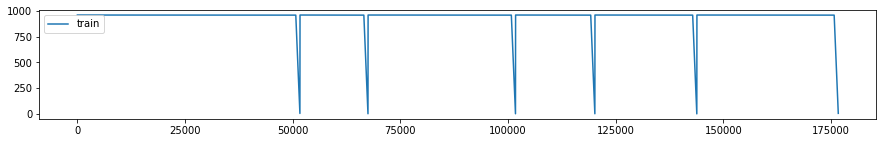

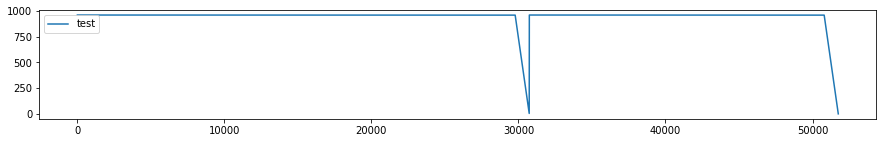

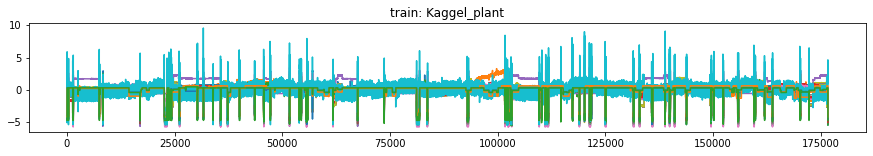

In [34]:
training_data = train_data_with_piecewise_rul.values
testing_data = test_data_with_piecewise_rul.values

x_train = training_data[:, 2:-1] # train data without "rul, rtf_id, cycle" columns
y_train = training_data[:, -1] # RUL per cycle
print("training", x_train.shape, y_train.shape)


x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)

plt.figure(figsize=(15,2))
plt.plot(y_train, label="train") # y_train[:500] contains cycle ruls for different engines
plt.legend()
plt.figure(figsize=(15,2))

plt.plot(y_test, label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train) # one could also restrict the plot to x_train[190] for example
plt.title("train: " + Data_id )

# Data_Batch Generation

In [35]:
sequence_length=5
window_size = 16
# Prepare the training set according to the  window size and sequence_length
x_batch, y_batch =batch_generator(train_data_with_piecewise_rul,sequence_length=sequence_length,window_size = window_size)

x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=1)

KeyboardInterrupt: 

In [ ]:
number_of_sensor = x_batch.shape[-2]

## Model

In [ ]:
from ECLSTM import ECLSTM1D
from ECLSTM import check_the_config_valid
from ECLSTM import build_the_model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# specify the achtecture parameters
para = {
    # preprocessing part
    "preprocessing_layers" : 0,
    "pre_kernel_width" : 3,
    "pre_number_filters" : 10,
    "pre_strides" : 2,
    "pre_activation" : "relu",


    # ECLSTM feature extraction part
    "eclstm_1_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_conv_activation" : ['hard_sigmoid',"hard_sigmoid"],
    "eclstm_1_kernel_width" : [3,3],
    "eclstm_1_number_filters" : [10,10],
    "eclstm_1_strides" : 1,
    "eclstm_1_fusion":["early","early"],
    
    "eclstm_2_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_conv_activation" : ['hard_sigmoid',"hard_sigmoid"],
    "eclstm_2_kernel_width" : [3,3],
    "eclstm_2_number_filters" : [20,20],
    "eclstm_2_strides" : 1,
    "eclstm_2_fusion":["early","early"],

    "eclstm_3_recurrent_activation" : [None],
    "eclstm_3_conv_activation" : [None],
    "eclstm_3_kernel_width" : [None],
    "eclstm_3_number_filters" : [None],
    "eclstm_3_strides" : None,
    "eclstm_3_fusion":[None],

    "eclstm_4_recurrent_activation" : [None],
    "eclstm_4_conv_activation" : [None],
    "eclstm_4_kernel_width" : [None],
    "eclstm_4_number_filters" : [None],
    "eclstm_4_strides" : None,
    "eclstm_4_fusion":[None],

    # Prediction
    "prediction_1_filters" : 150,
    "prediction_1_activation" : "relu",
    
    "prediction_2_filters" : 0,
    "prediction_2_activation" : None,
    
    "prediction_3_filters" : 0,
    "prediction_3_activation" : None,
    
    "prediction_4_filters" : 0,
    "prediction_4_activation" : None,
}

In [ ]:
valid = check_the_config_valid(para,window_size,number_of_sensor)
if valid:
    model = build_the_model(para, sequence_length, window_size, number_of_sensor)
else: 
    print("invalid configuration")
input_data = tf.keras.layers.Input(shape=(sequence_length, window_size, number_of_sensor,1))
out = model(input_data)
print(model.summary())

valid Configuration!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 5, 12, 1, 10)     6740      
 er)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 12, 1, 10)     40        
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None,

# Train the model

In [ ]:
dateTimeObj = datetime.now()

log_dir = "logs/{}_{}_{}_{}_{}_{}_{}/".format(Data_id,
                                              dateTimeObj.year,
                                              dateTimeObj.month,
                                              dateTimeObj.day,
                                              dateTimeObj.hour,
                                              dateTimeObj.minute,
                                              dateTimeObj.second)


os.makedirs(log_dir)

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

In [ ]:
# if you have enough time budget, you can set a large epochs and large patience

if load_optimzed_model == False: 
    model.fit(x_batch,y_batch, 
            batch_size=15, 
            epochs=2, 
            callbacks=[#logging, 
                        checkpoint, 
                        reduce_lr, 
                        early_stopping],
            validation_split=0.075)
    model.save_weights(log_dir + 'trained_weights_final.h5')

Epoch 1/2
10887/10887 [==============================] - 282s 25ms/step - loss: 14366.6611 - val_loss: 23137.6094 - lr: 0.0010
Epoch 2/2
10887/10887 [==============================] - 264s 24ms/step - loss: 3865.2566 - val_loss: 14190.3516 - lr: 0.0010


## Evaluation

In [ ]:
def evaluate(test_df): 

    x_batch_test, y_batch_test =  test_batch_generator(test_df, sequence_length=sequence_length,window_size = window_size)
    x_batch_test = np.expand_dims(x_batch_test, axis=4)

    def performance():

        # performance on training dataset
        y_batch_pred = model.predict(x_batch)

        y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
        y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
        rmse_on_train = np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

        print("The RMSE on Training dataset {} is {}.".format(Data_id,rmse_on_train))

        # performance on test dataset
        y_batch_pred_test = model.predict(x_batch_test)
        rmse_on_test = np.sqrt(mean_squared_error(y_batch_pred_test, y_batch_test))
        print("The RMSE on test dataset {} is {}.".format(Data_id,rmse_on_test))

    if load_optimzed_model == False:
        modellist = os.listdir(log_dir)
        modellist = [file for file in modellist if "val_loss" in file]

        model.load_weights(log_dir+modellist[-1])

        return performance()
        
    if load_optimzed_model == True: 
        print("loading optimzed model ...")
        
        model_id=4
        model_weights = 'trained_models/{}/best_model_{}_{}.h5'.format(Data_id,Data_id,model_id)
        if not os.path.exists(model_weights):
            print("no such a weight file")
        else:
            model.load_weights(model_weights)

        return performance()
            
    

In [ ]:
evaluate(test_data_with_piecewise_rul)

5517/5517 [==============================] - 25s 4ms/step
The RMSE on Training dataset Kaggel_plant is 69.80679321289062.
1/1 [==============================] - 1s 672ms/step
The RMSE on test dataset Kaggel_plant is 925.8952026367188.


# Testing the notebook with the help of automated RUl 

In [36]:
from rul import RemainingUsefulLife

In [37]:
test  = RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, max_life=2*8*60)

training (176658, 23) (176658,)
testing (51754, 23) (51754,)
valid Configuration!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 5, 12, 1, 10)     6740      
 er)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 12, 1, 10)     40        
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                        

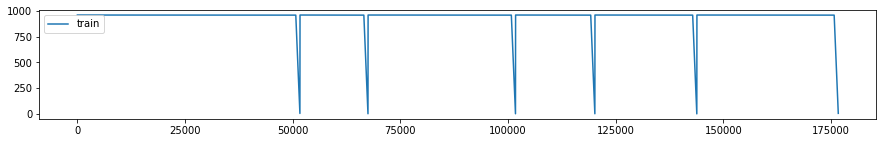

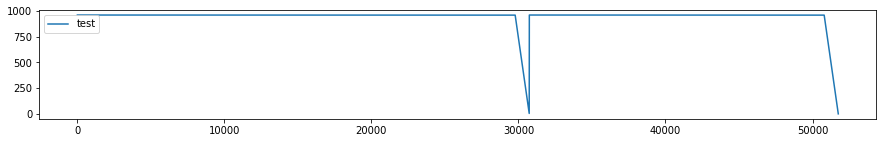

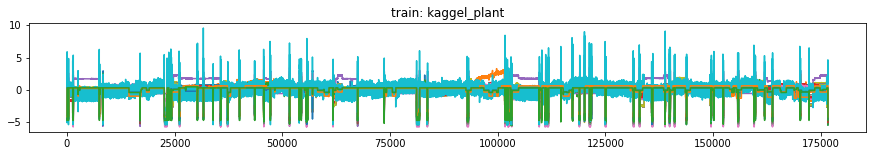

In [38]:
test.auto_rul()